In [1]:
from time import sleep

import gym
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from reinforcement_learning.utils.agent import Agent
from reinforcement_learning.utils.dataset import Dataset
from reinforcement_learning.utils.learner import Learner
from reinforcement_learning.utils.policy import Policy


In [2]:
np.set_printoptions(precision=2)

environment = gym.make('CartPole-v0')

In [3]:
environment.action_space

Discrete(2)

In [4]:
environment.action_space.sample()

0

In [5]:
environment.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [6]:
initial_state = environment.reset()
initial_state

array([ 0.02,  0.03, -0.02, -0.  ])

In [7]:
environment.step(action=1)

(array([ 0.02,  0.23, -0.02, -0.3 ]), 1.0, False, {})

In [9]:
environment = gym.make('CartPole-v0')

state = environment.reset()
done = False
while not done:
    action = environment.action_space.sample()
    state, reward, done, info = environment.step(action=action)
    environment.render()
    sleep(0.1)
environment.close()

In [10]:
environment = gym.make('CartPole-v0')

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = environment.action_space.sample()
        state, reward, done, info = environment.step(action=action)

In [11]:
environment = gym.make('CartPole-v0')

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = environment.action_space.sample()
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

<AxesSubplot:>

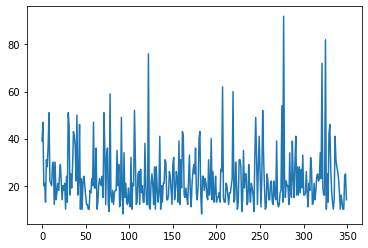

In [12]:
pd.Series(cumulative_rewards).plot()

In [ ]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

state = environment.reset()
done = False
while not done:
    action = agent.select_action(state=state)
    state, reward, done, info = environment.step(action=action)

In [30]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)

In [30]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

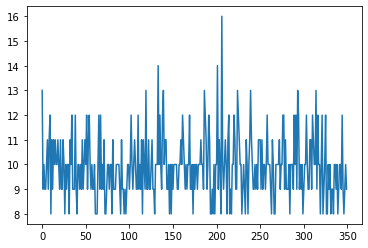

In [31]:
pd.Series(cumulative_rewards).plot()


In [56]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state

In [58]:
state, action, reward, next_state, done = dataset.sample(1)[0]

# Convert types
state = torch.Tensor(state)
next_state = torch.Tensor(next_state)

# Compute loss
q = policy.model(state)[action]
next_values = policy.model(next_state)

if not done:
    loss = (q - reward - next_values.max()) ** 2
else:
    loss = (q - reward) ** 2


In [ ]:
environment = gym.make('CartPole-v0')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, 0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)

## Train until winning 5 times in a row

In [67]:
import copy

In [74]:
environment = gym.make('CartPole-v0')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)
agents = []

cumulative_rewards = []
is_winner = False
for episode in tqdm(range(35000)):
    if is_winner:
        break
    cumulative_reward = 0
    # run episode
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, epsilon=0.15)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

    # evaluate agent
    if episode % 25 == 0:
        agents.append(copy.deepcopy(agent))
        for _ in range(5):
            total_reward = 0
            state = environment.reset()
            done = False
            while not done:
                action = agent.select_action(state)
                state, reward, done, info = environment.step(action=action)
                total_reward += reward
            if total_reward < 190:
                is_winner = False
                break
            is_winner = True

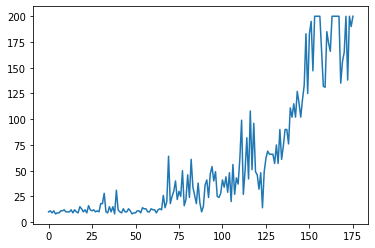

In [75]:
pd.Series(cumulative_rewards).plot()

In [79]:
from gym import wrappers

environment = gym.make('CartPole-v0')

for i, a in enumerate([agents[0]] + agents[-5:]):
    environment = wrappers.Monitor(environment, f'./videito_{i}', force=True)
    state = environment.reset()
    done = False
    while not done:
        action = a.select_action(state)
        state, reward, done, info = environment.step(action=action)
        environment.render()
        sleep(0.1)
    environment.close()

In [71]:
agents